In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime
import shapely.geometry
import matplotlib.pyplot as plt
from defined_methods import merge_csv, merge_csv_flow, normalize_plot

# Data preparation

In [2]:
# read the administrative relationship encoding file
admin_rel = pd.read_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/oa_lsoa_msoa_la_trans.csv')

# read the spatial administrative boundary files
oa = gpd.read_file(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_oa.gpkg')
# lsoa = gpd.read_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_lsoa.gpkg')
msoa = gpd.read_file(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_msoa.gpkg')

inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)
msoa = msoa.explode(index_parts=True).reset_index(drop=True)

msoa_joined = gpd.sjoin(msoa, inoutter[['Boundary', 'geometry']], how='inner', predicate='intersects')

msoa_joined.rename(columns={'Boundary': 'inout'}, inplace=True)

# Calculate intersection area for each row in the joined DataFrame
msoa_joined['intersection_area'] = msoa_joined.apply(
    lambda row: row.geometry.intersection(inoutter.loc[row.index_right].geometry).area,
    axis=1
)
msoa_joined.drop(columns=['index_right'], inplace=True)

# Group by MSOA code, and keep the record with the largest intersection area within each group
msoa_filtered = msoa_joined.sort_values('intersection_area', ascending=False).drop_duplicates(subset=['msoa21cd'])
# Merge the filtered results back with the original MSOA DataFrame to include the 'Boundary' tags
msoa = pd.merge(msoa, msoa_filtered[['msoa21cd', 'inout']], on='msoa21cd', how='left')

msoa = msoa.drop([63, 74, 934])
# msoa.plot()
# plt.axis('off')

# Check the geometry types in the GeoDataFrame
geometry_types = msoa.geometry.type

# Find if there are any MultiPolygons
has_multipolygons = 'MultiPolygon' in geometry_types.unique()

print("Contains MultiPolygon geometries:", has_multipolygons)

# If you want to count how many MultiPolygons there are:
multipolygon_count = (geometry_types == 'MultiPolygon').sum()
print("Number of MultiPolygon geometries:", multipolygon_count)

# Optionally, to get the indices or identifiers of features with MultiPolygon geometries:
multipolygon_indices = msoa[geometry_types == 'MultiPolygon'].index
print("Indices of MultiPolygon geometries:", multipolygon_indices.tolist())

# Or, if your GeoDataFrame has an identifier column, e.g., 'msoa11cd':
if 'msoa11cd' in msoa.columns and has_multipolygons:
    multipolygon_ids = msoa.loc[geometry_types == 'MultiPolygon', 'msoa11cd']
    print("IDs of MultiPolygon geometries:", multipolygon_ids.tolist())


Contains MultiPolygon geometries: False
Number of MultiPolygon geometries: 0
Indices of MultiPolygon geometries: []


In [3]:
# Behavioural data loading
device = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/device')
stay_time = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/stay time')
travel_time = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/travel time')
# drop the na values in the stay time dataset
stay_time = stay_time.dropna()
# convert the stay time from seconds to hours
stay_time['stay_time'] = stay_time['stay_time'].astype(int) / 3600

# Filtering for March 1, 2022, and March 3, 2022

device_313 = device[(device['date'] == '02/22/22') | (device['date'] == '03/01/22') | (
        device['date'] == '03/03/22')].copy().reset_index(drop=True)
device_313['date'] = pd.to_datetime(device_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

stay_time_313 = stay_time[(stay_time['date'] == '02/22/22') | (stay_time['date'] == '03/01/22') | (
        stay_time['date'] == '03/03/22')].copy().reset_index(
    drop=True)
stay_time_313['date'] = pd.to_datetime(stay_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

travel_time_313 = travel_time[
    (travel_time['date'] == '02/22/22') | (travel_time['date'] == '03/01/22') | (
            travel_time['date'] == '03/03/22')].copy().reset_index(drop=True)
travel_time_313['date'] = pd.to_datetime(travel_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

# Behavioural data processing
device_313_status = pd.merge(device_313, stay_time_313, on=['startid', 'date', 'oa21cd', 'device_type'], how='left')
device_313_status = device_313_status.drop_duplicates().reset_index(drop=True)

# insert the MSOA and LSOA column from 'admin_rel'
device_313_status = pd.merge(device_313_status, admin_rel[['oa21cd', 'msoa21cd', 'lsoa21cd']], on=['oa21cd'],
                             how='left')
device_313_status = device_313_status.drop_duplicates().reset_index(drop=True)

device_313_modes = travel_time_313.groupby(['stripid', 'startid', 'date', 'update_mode']).agg(
    {'time': 'sum', 'distance': 'sum'}).reset_index()

# Indicators building

In [4]:
# merge dfs to aggrate at MSOA level
device_313_merged = pd.merge(device_313_status, device_313_modes, on=['date', 'startid'], how='left')

# drop duplicates
counts = device_313_merged.groupby(['date', 'msoa21cd', 'device_type', 'update_mode']).size().reset_index(name='count')

counts = counts.rename_axis(None, axis=1)

counts_total = counts.groupby(['date', 'device_type'])['count'].sum().reset_index()
counts_total_modes = counts.groupby(['date', 'update_mode', 'device_type'])['count'].sum().reset_index()
counts_msoa_modes = counts.groupby(['date', 'device_type', 'msoa21cd', 'update_mode'])['count'].sum().reset_index()
counts_msoa_total = counts_msoa_modes.groupby(['date', 'device_type', 'msoa21cd'])['count'].sum().reset_index()



In [5]:
# The units of 'time' and 'distance' are hours and kilometers, respectively

triptd_msoa_modes = device_313_merged.groupby(['date', 'msoa21cd', 'device_type', 'update_mode']).agg(
    time_sum=('time', 'sum'), distance_sum=('distance', 'sum')).reset_index().round(2)
triptd_msoa_total = device_313_merged.groupby(['date', 'msoa21cd', 'device_type']).agg(time_sum=('time', 'sum'),
                                                                                       distance_sum=('distance',
                                                                                                     'sum')).reset_index().round(
    2)
triptd_total = device_313_merged.groupby(['date', 'device_type']).agg(time_sum=('time', 'sum'), distance_sum=(
    'distance', 'sum')).reset_index().round(2)
triptd_total_modes = device_313_merged.groupby(['date', 'device_type', 'update_mode']).agg(time_sum=('time', 'sum'),
                                                                                           distance_sum=('distance',
                                                                                                         'sum')).reset_index().round(
    2)

# Calculate the means
triptd_msoa_modes_means = device_313_merged.groupby(['date', 'msoa21cd', 'device_type', 'update_mode'])[
    ['time', 'distance']].mean().reset_index().round(2).rename(
    columns={'time': 'time_mean', 'distance': 'distance_mean'})
triptd_msoa_total_means = device_313_merged.groupby(['date', 'msoa21cd', 'device_type'])[
    ['time', 'distance']].mean().reset_index().round(2).rename(
    columns={'time': 'time_mean', 'distance': 'distance_mean'})
triptd_total_means = device_313_merged.groupby(['date', 'device_type'])[
    ['time', 'distance']].mean().reset_index().round(2).rename(
    columns={'time': 'time_mean', 'distance': 'distance_mean'})
triptd_total_modes_means = device_313_merged.groupby(['date', 'device_type', 'update_mode'])[
    ['time', 'distance']].mean().reset_index().round(2).rename(
    columns={'time': 'time_mean', 'distance': 'distance_mean'})

# Merge the means with the original aggregated data
triptd_msoa_modes = pd.merge(triptd_msoa_modes, triptd_msoa_modes_means,
                             on=['date', 'msoa21cd', 'device_type', 'update_mode'])
triptd_msoa_total = pd.merge(triptd_msoa_total, triptd_msoa_total_means, on=['date', 'msoa21cd', 'device_type'])
triptd_total = pd.merge(triptd_total, triptd_total_means, on=['date', 'device_type'])
triptd_total_modes = pd.merge(triptd_total_modes, triptd_total_modes_means, on=['date', 'device_type', 'update_mode'])

triptd_msoa_modes.rename_axis(None, axis=1, inplace=True)
triptd_msoa_total.rename_axis(None, axis=1, inplace=True)
triptd_total.rename_axis(None, axis=1, inplace=True)
triptd_total_modes.rename_axis(None, axis=1, inplace=True)


In [6]:
def triprate(df, msoa=False):
    df = df.copy()

    if msoa == False:
        df = df.pivot_table(index=['date', 'device_type'], columns='update_mode', values='count',
                            fill_value=0).reset_index()
        df.rename_axis(None, axis=1, inplace=True)
    else:
        df = df.pivot_table(index=['date', 'msoa21cd', 'device_type'], columns='update_mode', values='count',
                            fill_value=0).reset_index()
        df.rename_axis(None, axis=1, inplace=True)

    df['public_transportation'] = df['tube'] + df['bus'] + df['train']
    df['movement'] = df['public_transportation'] + df['car'] + df['cycle'] + df['walks']
    df['bus'] = (df['bus'] / (df['movement'] + df['stationary'])).round(4)
    df['car'] = (df['car'] / (df['movement'] + df['stationary'])).round(4)
    df['cycle'] = (df['cycle'] / (df['movement'] + df['stationary'])).round(4)
    df['walks'] = (df['walks'] / (df['movement'] + df['stationary'])).round(4)
    df['train'] = (df['train'] / (df['movement'] + df['stationary'])).round(4)
    df['tube'] = (df['tube'] / (df['movement'] + df['stationary'])).round(4)
    df['public_to_movement'] = (df['public_transportation'] / df['movement']).round(4)
    df['public_transportation'] = (df['public_transportation'] / (df['movement'] + df['stationary'])).round(4)
    df['movement_rate'] = (df['movement'] / (df['movement'] + df['stationary'])).round(4)
    df['stationary_rate'] = (df['stationary'] / (df['movement'] + df['stationary'])).round(4)
    df.drop(columns=['stationary', 'movement'], inplace=True)
    df = df.rename(columns={'stationary_rate': 'stationary', 'movement_rate': 'movement'})
    return df


triprate_total = triprate(counts_total_modes)
triprate_msoa = triprate(counts_msoa_modes, msoa=True)


In [7]:
total = pd.merge(counts_total, triptd_total, on=['date', 'device_type'], how='left')
total = pd.merge(total, triprate_total, on=['date', 'device_type'], how='left')
total

,date,device_type,count,time_sum,distance_sum,time_mean,distance_mean,bus,car,cycle,train,tube,walks,public_transportation,public_to_movement,movement,stationary
0,02/22/22,attraction,1164248,2227944.08,4.003151e+06,1.91,3.44,0.0273,0.2390,0.0150,0.0099,0.0153,0.2433,0.0525,0.0955,0.5498,0.4502
1,02/22/22,passthrough,20266462,40130579.11,1.262609e+08,1.98,6.23,0.0294,0.2919,0.0191,0.0132,0.0273,0.1938,0.0699,0.1216,0.5747,0.4253
2,02/22/22,resident,561472,1527447.21,1.746879e+06,2.72,3.11,0.0260,0.2264,0.0141,0.0068,0.0126,0.2299,0.0453,0.0879,0.5157,0.4843
3,03/01/22,attraction,1065961,2101016.25,3.500017e+06,1.97,3.28,0.0275,0.2433,0.0190,0.0082,0.0113,0.2414,0.0470,0.0853,0.5507,0.4493
4,03/01/22,passthrough,20437417,41199291.44,1.266668e+08,2.02,6.20,0.0297,0.2918,0.0276,0.0114,0.0248,0.1968,0.0659,0.1132,0.5820,0.4180
5,03/01/22,resident,531007,1502381.58,1.607029e+06,2.83,3.03,0.0260,0.2300,0.0179,0.0057,0.0093,0.2264,0.0410,0.0796,0.5153,0.4847
6,03/03/22,attraction,1139118,2179385.31,3.720933e+06,1.91,3.27,0.0281,0.2388,0.0181,0.0079,0.0112,0.2444,0.0472,0.0860,0.5485,0.4515
7,03/03/22,passthrough,20110772,39350631.91,1.248098e+08,1.96,6.21,0.0301,0.2895,0.0248,0.0110,0.0248,0.1970,0.0659,0.1142,0.5772,0.4228
8,03/03/22,resident,557258,1504081.77,1.678156e+06,2.70,3.01,0.0270,0.2252,0.0167,0.0054,0.0092,0.2319,0.0416,0.0806,0.5154,0.4846


In [8]:
total_modes = pd.merge(counts_total_modes, triptd_total_modes, on=['date', 'device_type', 'update_mode'], how='left')
total_modes

,date,update_mode,device_type,count,time_sum,distance_sum,time_mean,distance_mean
0,02/22/22,bus,attraction,31753,15232.47,8.855946e+04,0.48,2.79
1,02/22/22,bus,passthrough,596057,271682.84,1.752646e+06,0.46,2.94
2,02/22/22,bus,resident,14575,7720.49,4.050783e+04,0.53,2.78
3,02/22/22,car,attraction,278289,263174.42,2.889805e+06,0.95,10.38
4,02/22/22,car,passthrough,5914911,7928098.83,1.039595e+08,1.34,17.58
...,...,...,...,...,...,...,...,...
58,03/03/22,tube,passthrough,499110,230908.77,3.796444e+06,0.46,7.61
59,03/03/22,tube,resident,5119,2116.14,3.100504e+04,0.41,6.06
60,03/03/22,walks,attraction,278381,200938.51,3.715814e+05,0.72,1.33
61,03/03/22,walks,passthrough,3961684,2804367.04,5.515432e+06,0.71,1.39


In [9]:
msoa_total = pd.merge(counts_msoa_total, triptd_msoa_total, on=['date', 'msoa21cd', 'device_type'], how='left')
msoa_total = pd.merge(msoa_total, triprate_msoa, on=['date', 'msoa21cd', 'device_type'], how='left')
msoa_total = pd.merge(msoa_total, msoa[['msoa21cd', 'msoa21nm', 'inout', 'geometry']], on=['msoa21cd'], how='left')
msoa_total

,date,device_type,msoa21cd,count,time_sum,distance_sum,time_mean,distance_mean,bus,car,...,train,tube,walks,public_transportation,public_to_movement,movement,stationary,msoa21nm,inout,geometry
0,02/22/22,attraction,E02000001,31564,54276.42,153155.22,1.72,4.85,0.0247,0.1958,...,0.0438,0.0272,0.2925,0.0957,0.1612,0.5941,0.4059,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,02/22/22,attraction,E02000002,769,1395.38,1959.23,1.81,2.55,0.0208,0.2497,...,0.0013,0.0091,0.2354,0.0312,0.0588,0.5306,0.4694,Barking and Dagenham 001,Outer London,"POLYGON ((548881.304 190819.980, 548881.125 19..."
2,02/22/22,attraction,E02000003,1602,3254.25,4549.81,2.03,2.84,0.0231,0.2653,...,0.0044,0.0050,0.2191,0.0325,0.0611,0.5312,0.4688,Barking and Dagenham 002,Outer London,"POLYGON ((548958.555 189072.176, 548954.517 18..."
3,02/22/22,attraction,E02000004,1246,2540.49,3158.53,2.04,2.53,0.0241,0.2600,...,0.0024,0.0024,0.2279,0.0289,0.0544,0.5313,0.4687,Barking and Dagenham 003,Outer London,"POLYGON ((551550.056 187364.705, 551528.633 18..."
4,02/22/22,attraction,E02000005,1246,2690.91,3541.70,2.16,2.84,0.0233,0.2496,...,0.0024,0.0032,0.2400,0.0289,0.0549,0.5265,0.4735,Barking and Dagenham 004,Outer London,"POLYGON ((549237.051 187627.941, 549241.319 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9013,03/03/22,resident,E02007111,418,943.30,1034.06,2.26,2.47,0.0263,0.1842,...,0.0120,0.0215,0.2919,0.0598,0.1078,0.5550,0.4450,Hackney 033,Inner London,"POLYGON ((533467.193 183307.131, 533467.765 18..."
9014,03/03/22,resident,E02007112,181,712.24,368.06,3.94,2.03,0.0552,0.1657,...,0.0055,0.0110,0.2431,0.0718,0.1461,0.4917,0.5083,Tower Hamlets 034,Inner London,"POLYGON ((539048.000 181080.547, 539044.875 18..."
9015,03/03/22,resident,E02007113,312,773.72,875.24,2.48,2.81,0.0256,0.1731,...,0.0000,0.0064,0.3013,0.0321,0.0617,0.5192,0.4808,Tower Hamlets 035,Inner London,"POLYGON ((538560.000 181083.000, 538575.000 18..."
9016,03/03/22,resident,E02007114,294,716.83,698.69,2.44,2.38,0.0204,0.1395,...,0.0136,0.0170,0.3367,0.0510,0.0949,0.5374,0.4626,Tower Hamlets 036,Inner London,"POLYGON ((538406.587 180300.310, 538431.966 18..."


In [10]:
msoa_modes = pd.merge(counts_msoa_modes, triptd_msoa_modes, on=['date', 'msoa21cd', 'device_type', 'update_mode'],
                      how='left')
msoa_modes = pd.merge(msoa_modes, msoa[['msoa21cd', 'msoa21nm', 'inout', 'geometry']], on=['msoa21cd'], how='left')
msoa_modes

,date,device_type,msoa21cd,update_mode,count,time_sum,distance_sum,time_mean,distance_mean,msoa21nm,inout,geometry
0,02/22/22,attraction,E02000001,bus,781,347.68,2914.58,0.45,3.73,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
1,02/22/22,attraction,E02000001,car,6179,5013.10,85871.91,0.81,13.90,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
2,02/22/22,attraction,E02000001,cycle,319,188.44,2183.23,0.59,6.84,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,02/22/22,attraction,E02000001,stationary,12813,41343.81,3777.07,3.23,0.29,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
4,02/22/22,attraction,E02000001,train,1383,771.81,31050.08,0.56,22.45,City of London 001,Inner London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...
61445,03/03/22,resident,E02007115,cycle,13,3.81,29.25,0.29,2.25,Camden 029,Inner London,"POLYGON ((530861.849 182330.810, 530861.009 18..."
61446,03/03/22,resident,E02007115,stationary,508,1923.33,86.45,3.79,0.17,Camden 029,Inner London,"POLYGON ((530861.849 182330.810, 530861.009 18..."
61447,03/03/22,resident,E02007115,train,8,4.23,202.44,0.53,25.31,Camden 029,Inner London,"POLYGON ((530861.849 182330.810, 530861.009 18..."
61448,03/03/22,resident,E02007115,tube,17,5.99,88.96,0.35,5.23,Camden 029,Inner London,"POLYGON ((530861.849 182330.810, 530861.009 18..."


# Visualisation

In [11]:
import seaborn as sns

# Define the visual disabled friendly color palette
okabe_ito_colors = [
    '#E69F00',  # orange
    '#56B4E9',  # sky blue
    '#009E73',  # bluish green
    '#F0E442',  # yellow
    '#0072B2',  # blue
    '#D55E00',  # vermillion
    '#CC79A7',  # reddish purple
    '#999999',  # gray
]
sns.set_theme(style='white', palette=okabe_ito_colors, font='Proxima Nova', context='notebook', font_scale=1.5)

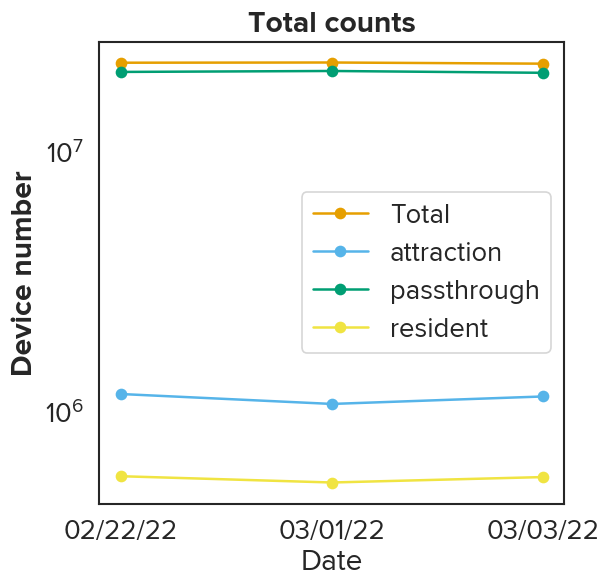

In [12]:
# for total
total_counts = total.groupby(['date']).agg({'count': 'sum'}).reset_index()

plt.figure(figsize=(5, 5), dpi=120)
plt.plot(total_counts['date'], total_counts['count'], marker='o')
for type in total['device_type'].unique():
    plt.plot(total[total['device_type'] == type]['date'], total[total['device_type'] == type]['count'], marker='o')

plt.yscale('log')
plt.title('Total counts', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Device number', fontweight='bold')
plt.legend(['Total'] + list(total['device_type'].unique()))
plt.show()




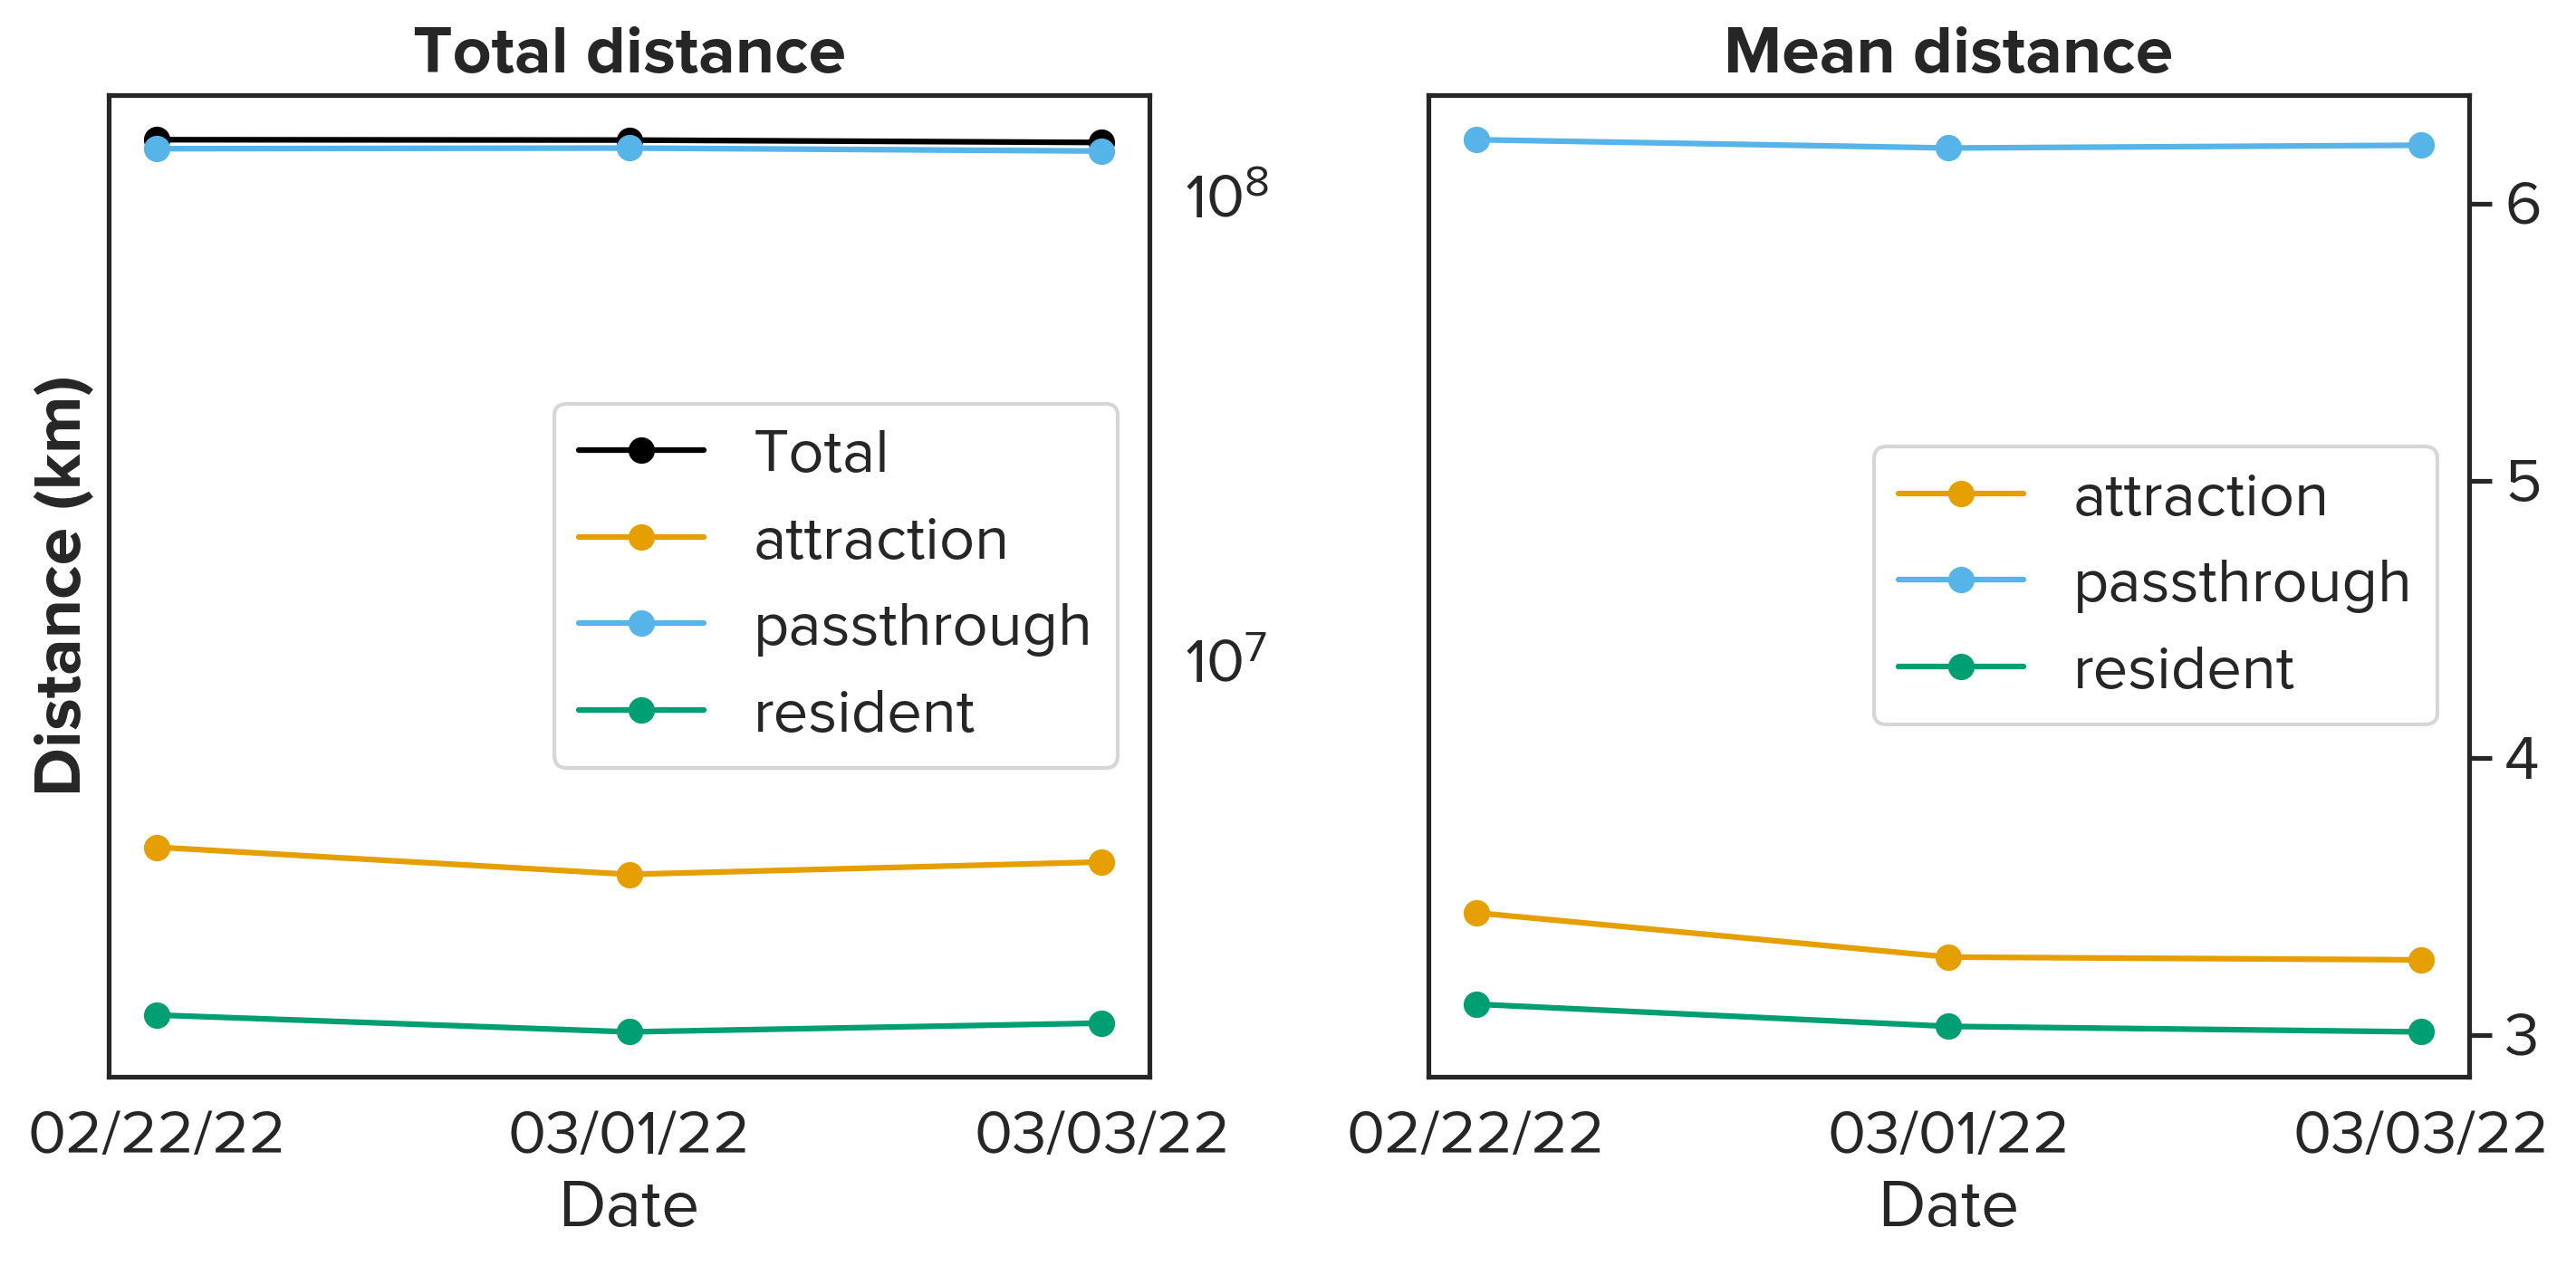

In [13]:
total_distance = total.groupby(['date']).agg({'distance_sum': 'sum'}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

axes[0].plot(total_distance['date'], total_distance['distance_sum'], marker='o', color='black')
for type in total['device_type'].unique():
    axes[0].plot(total[total['device_type'] == type]['date'], total[total['device_type'] == type]['distance_sum'],
                 marker='o')
axes[0].set_yscale('log')
axes[0].set_title('Total distance', fontweight='bold')
axes[0].set_ylabel('Distance (km)', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].legend(['Total'] + list(total['device_type'].unique()))
axes[0].tick_params(axis='y', which='both', labelleft=False, labelright=True)

for type in total['device_type'].unique():
    axes[1].plot(total[total['device_type'] == type]['date'], total[total['device_type'] == type]['distance_mean'],
                 marker='o')
axes[1].set_title('Mean distance', fontweight='bold')
axes[1].yaxis.tick_right()
axes[1].set_xlabel('Date')
axes[1].legend(list(total['device_type'].unique()))

plt.tight_layout()
plt.show()

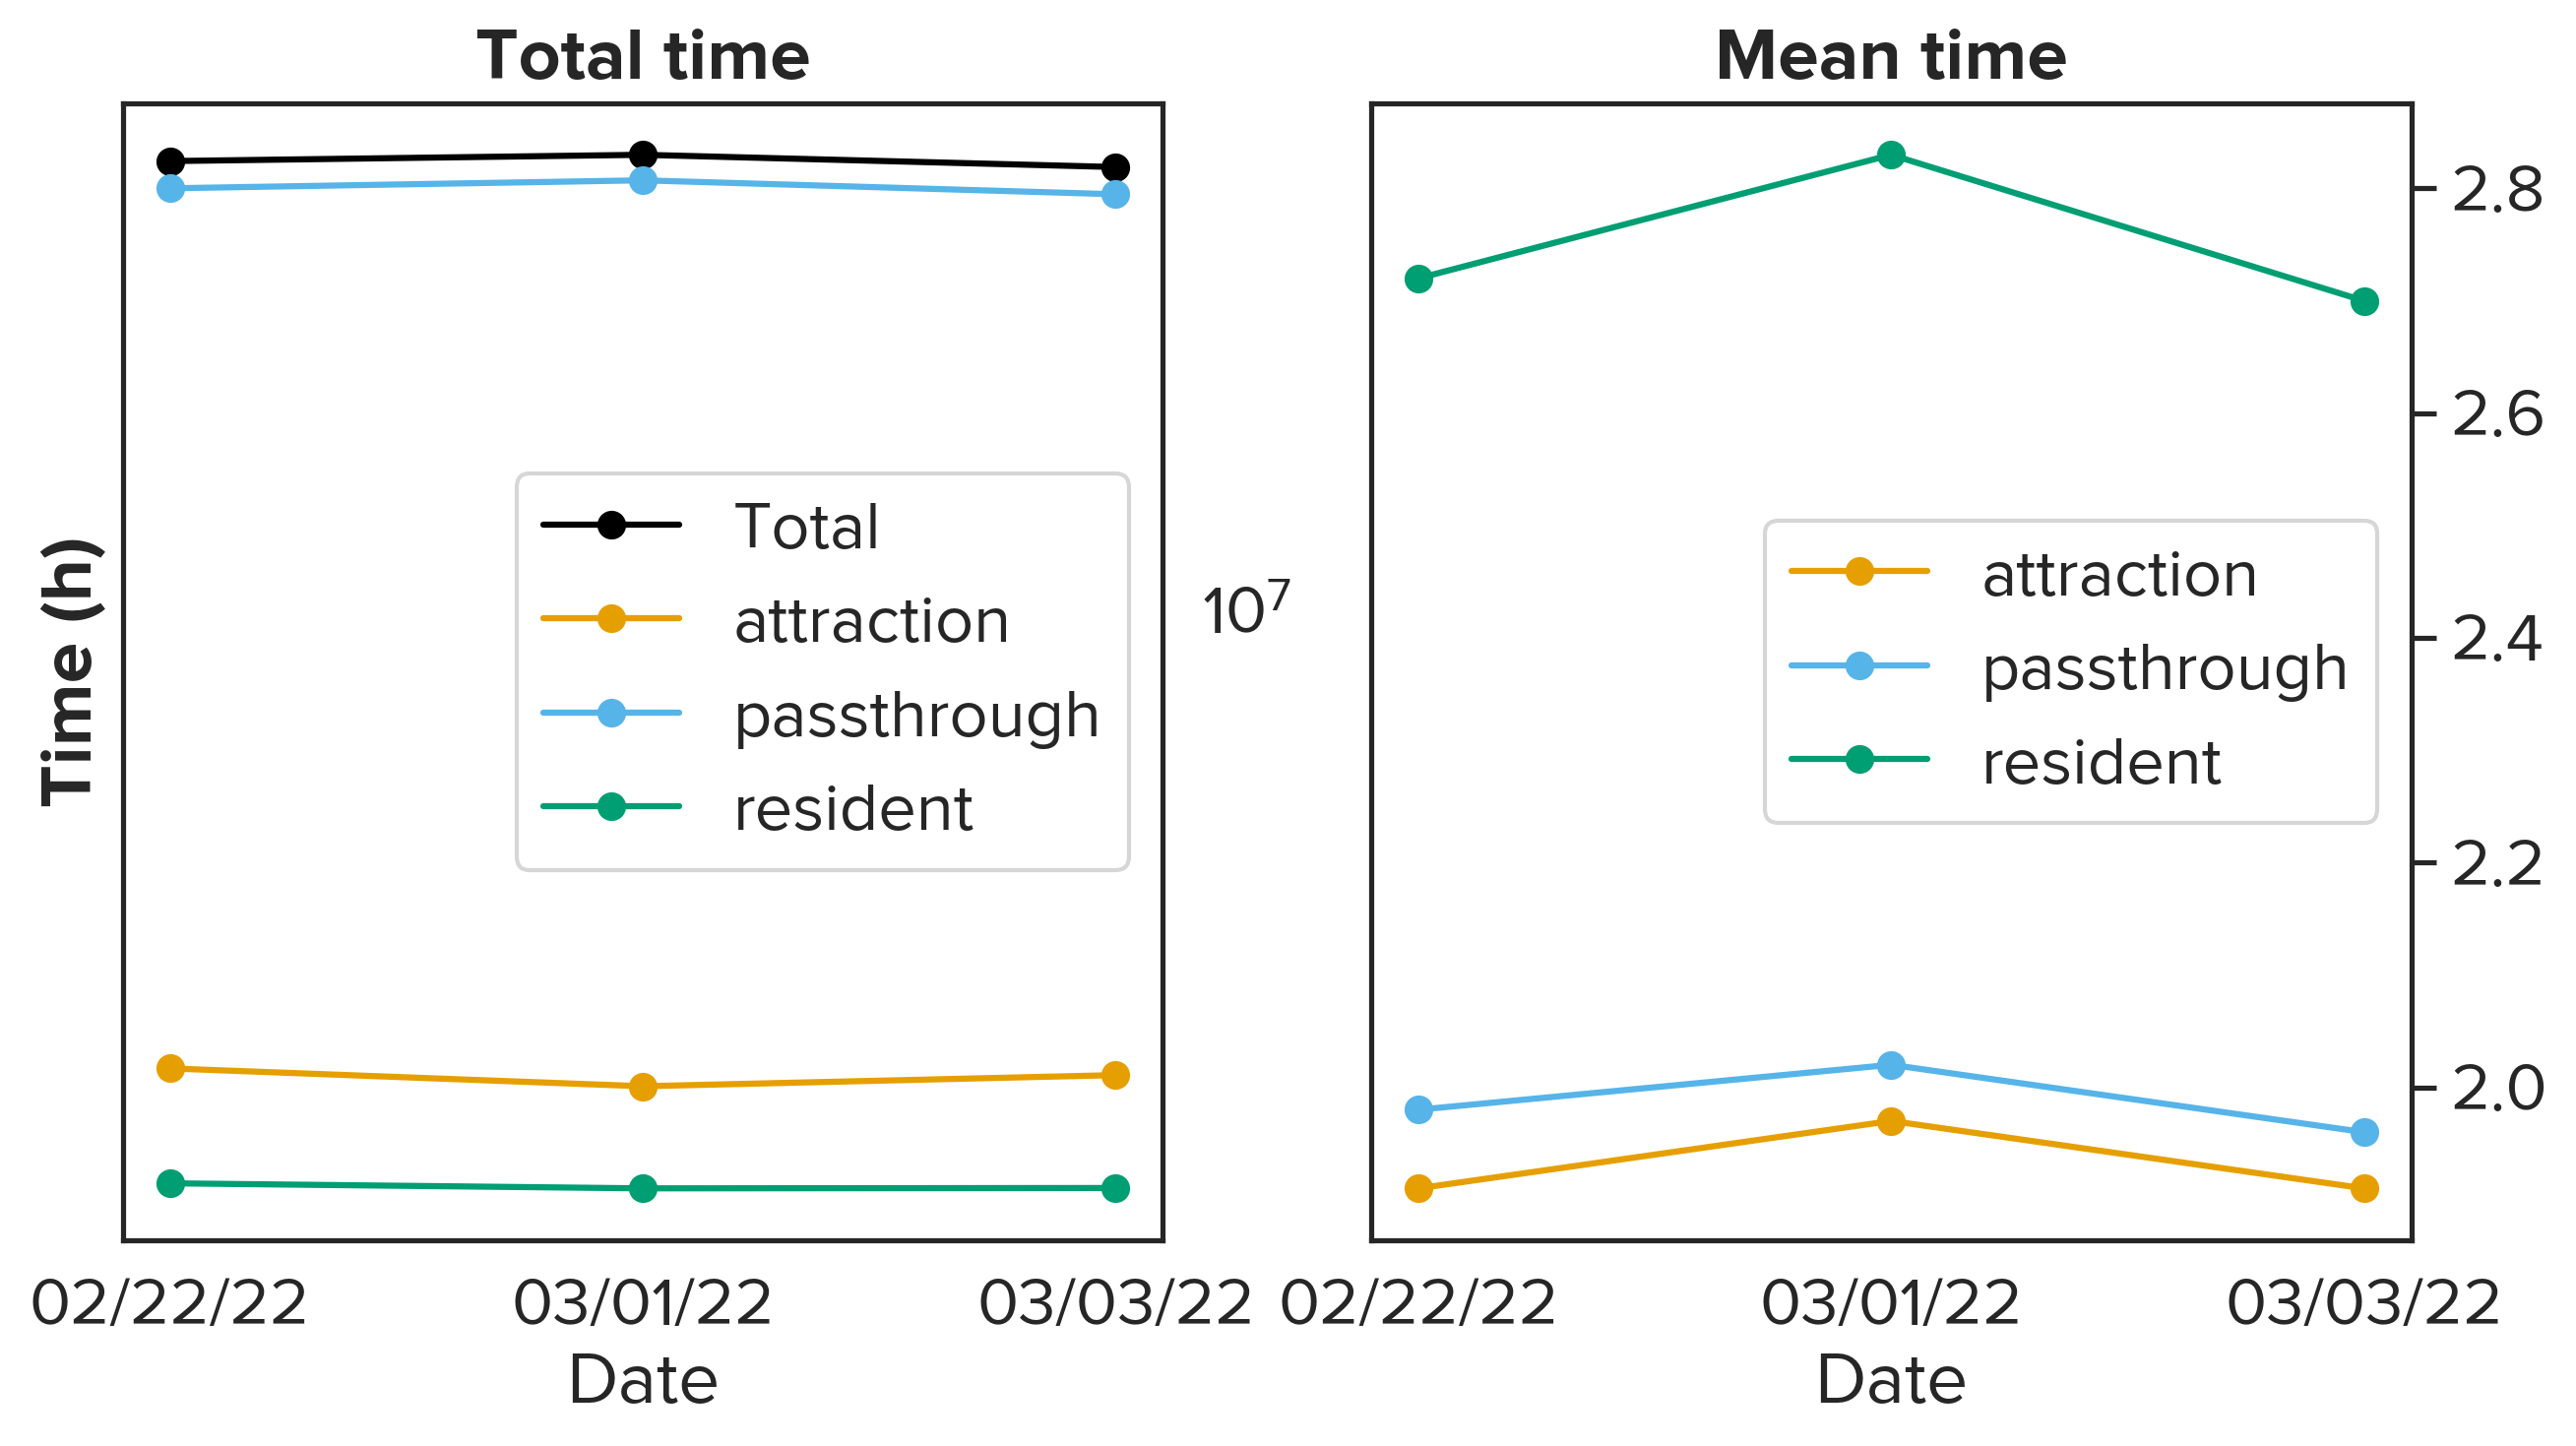

In [14]:
total_time = total.groupby(['date']).agg({'time_sum': 'sum'}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

axes[0].plot(total_time['date'], total_time['time_sum'], marker='o', color='black')
for type in total['device_type'].unique():
    axes[0].plot(total[total['device_type'] == type]['date'], total[total['device_type'] == type]['time_sum'],
                 marker='o')
axes[0].set_yscale('log')
axes[0].set_title('Total time', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Time (h)', fontweight='bold')
axes[0].legend(['Total'] + list(total['device_type'].unique()))
axes[0].tick_params(axis='y', which='both', labelleft=False, labelright=True)

for type in total['device_type'].unique():
    axes[1].plot(total[total['device_type'] == type]['date'], total[total['device_type'] == type]['time_mean'],
                 marker='o')
axes[1].set_title('Mean time', fontweight='bold')
axes[1].yaxis.tick_right()

axes[1].set_xlabel('Date')
axes[1].legend(list(total['device_type'].unique()))

plt.show()

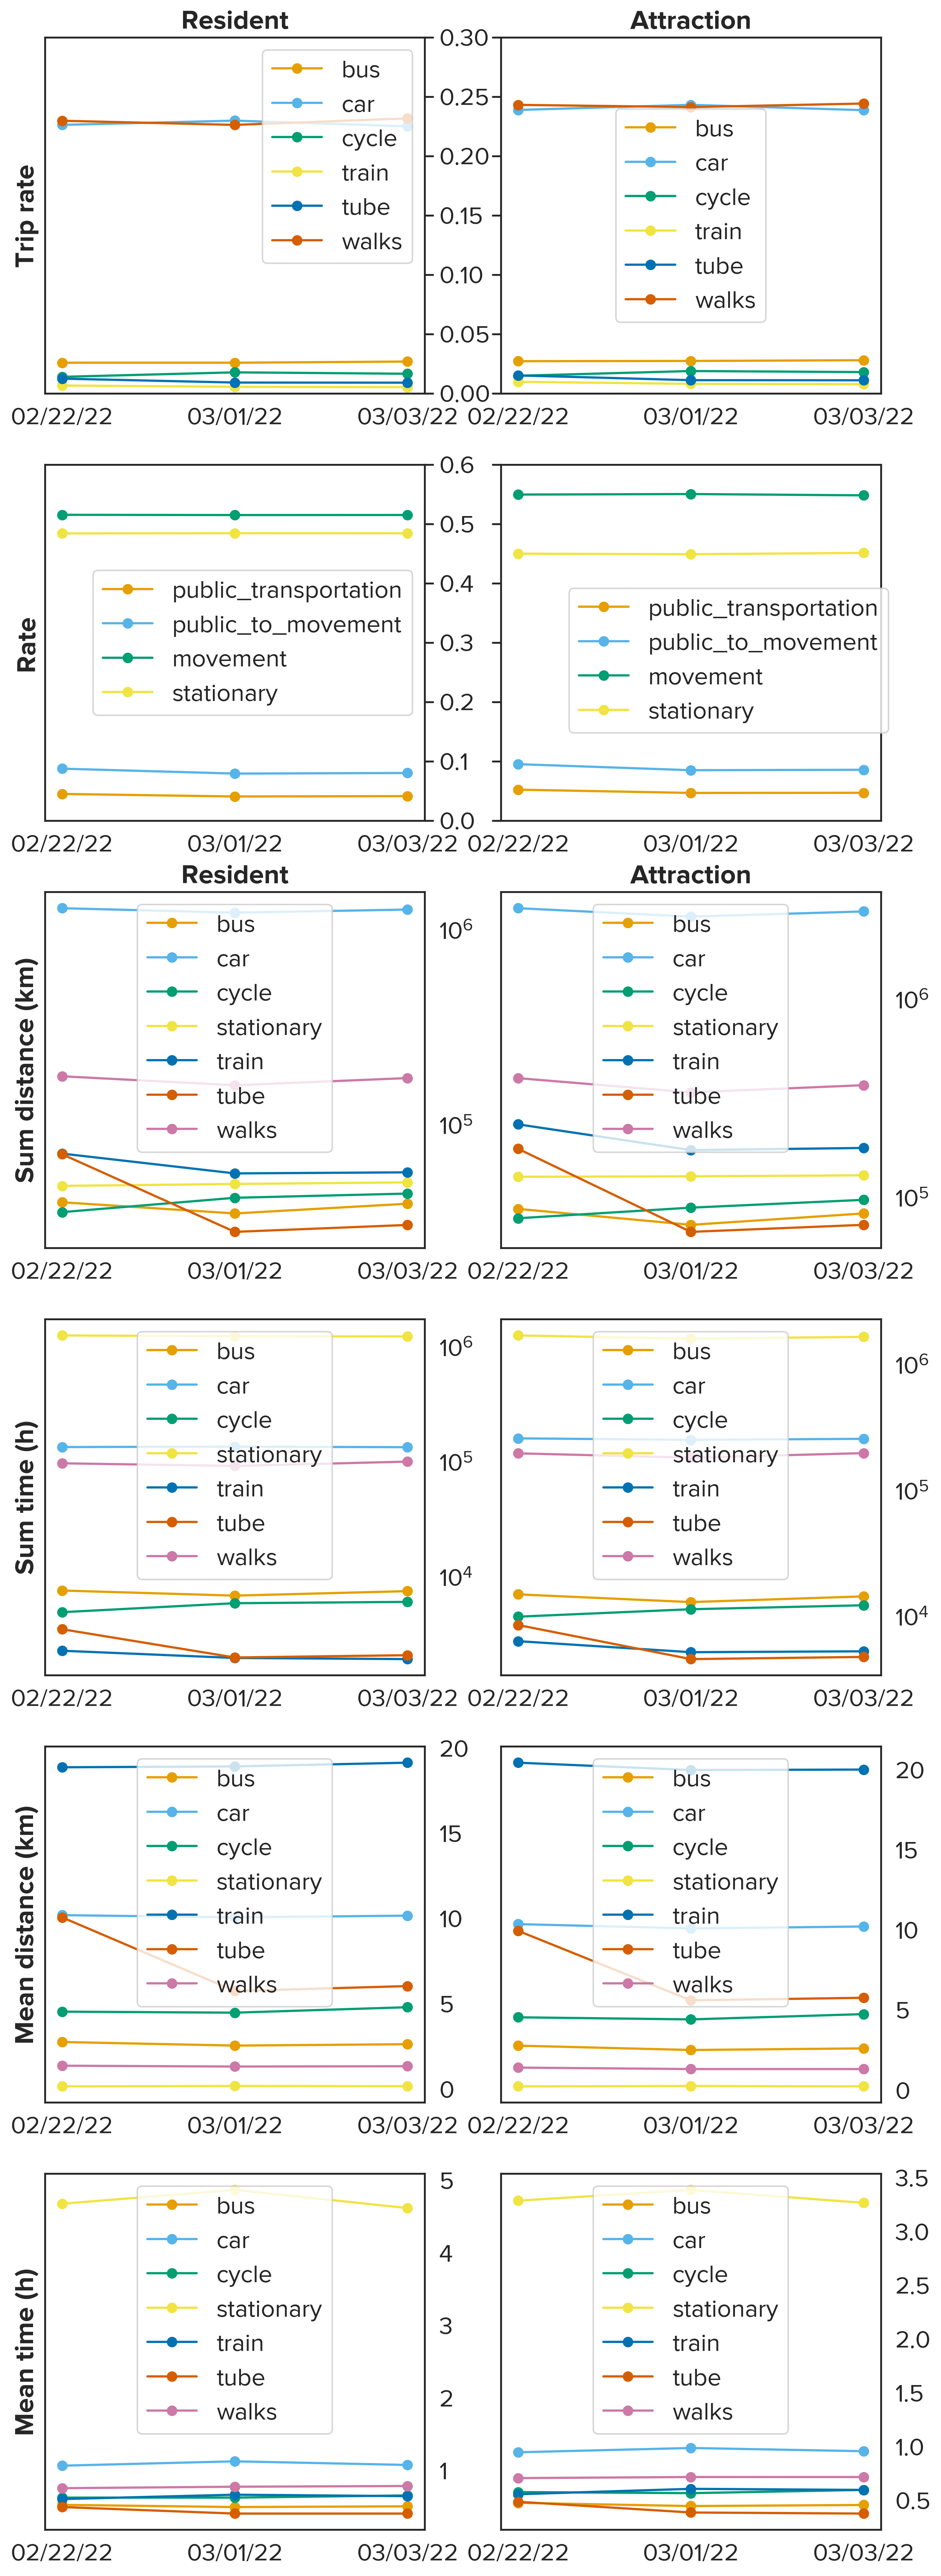

In [15]:
fig, axes = plt.subplots(6, 2, figsize=(10, 30), dpi=300)

for col in total.columns[7:13]:
    axes[0, 0].plot(total[total['device_type'] == 'resident']['date'], total[total['device_type'] == 'resident'][col],
                    marker='o')
    axes[0, 1].plot(total[total['device_type'] == 'attraction']['date'],
                    total[total['device_type'] == 'attraction'][col], marker='o')
for col in total.columns[13:]:
    axes[1, 0].plot(total[total['device_type'] == 'resident']['date'], total[total['device_type'] == 'resident'][col],
                    marker='o')
    axes[1, 1].plot(total[total['device_type'] == 'attraction']['date'],
                    total[total['device_type'] == 'attraction'][col], marker='o')

for mode in total_modes['update_mode'].unique():
    # Filter for resident and attraction separately but ensure both device_type and update_mode match
    resident_filtered = total_modes[(total_modes['device_type'] == 'resident') & (total_modes['update_mode'] == mode)]
    attraction_filtered = total_modes[
        (total_modes['device_type'] == 'attraction') & (total_modes['update_mode'] == mode)]
    if not resident_filtered.empty:
        axes[2, 0].plot(resident_filtered['date'], resident_filtered['distance_sum'], marker='o', label=mode)
        axes[3, 0].plot(resident_filtered['date'], resident_filtered['time_sum'], marker='o', label=mode)
        axes[4, 0].plot(resident_filtered['date'], resident_filtered['distance_mean'], marker='o', label=mode)
        axes[5, 0].plot(resident_filtered['date'], resident_filtered['time_mean'], marker='o', label=mode)
    if not attraction_filtered.empty:
        axes[2, 1].plot(attraction_filtered['date'], attraction_filtered['distance_sum'], marker='o', label=mode)
        axes[3, 1].plot(attraction_filtered['date'], attraction_filtered['time_sum'], marker='o', label=mode)
        axes[4, 1].plot(attraction_filtered['date'], attraction_filtered['distance_mean'], marker='o', label=mode)
        axes[5, 1].plot(attraction_filtered['date'], attraction_filtered['time_mean'], marker='o', label=mode)

axes[0, 0].set_title('Resident', fontweight='bold')
axes[0, 0].set_ylim(0, 0.3)
axes[0, 0].yaxis.tick_right()
axes[0, 0].set_ylabel('Trip rate', fontweight='bold')
axes[0, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[0, 0].legend(total.columns[7:13])

axes[0, 1].set_title('Attraction', fontweight='bold')
axes[0, 1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axes[0, 1].set_ylim(0, 0.3)
axes[0, 1].yaxis.tick_left()
axes[0, 1].legend(total.columns[7:13])

axes[1, 0].set_ylim(0, 0.6)
axes[1, 0].yaxis.tick_right()
axes[1, 0].set_ylabel('Rate', fontweight='bold')
axes[1, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[1, 0].legend(total.columns[13:])

axes[1, 1].set_ylim(0, 0.6)

axes[1, 1].yaxis.tick_left()
axes[1, 1].legend(total.columns[13:], loc='center', bbox_to_anchor=(0.6, 0.45))
axes[1, 1].tick_params(axis='y', which='both', labelleft=False, labelright=False)

axes[2, 0].set_yscale('log')
axes[2, 0].set_title('Resident', fontweight='bold')
axes[2, 0].set_ylabel('Sum distance (km)', fontweight='bold')
# axes[2,0].yaxis.tick_right()
axes[2, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[2, 0].legend(total_modes['update_mode'].unique())

axes[2, 1].set_yscale('log')
axes[2, 1].set_title('Attraction', fontweight='bold')
# axes[2,1].yaxis.tick_left()
axes[2, 1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[2, 1].legend(total_modes['update_mode'].unique())

axes[3, 0].set_yscale('log')
axes[3, 0].set_ylabel('Sum time (h)', fontweight='bold')
# axes[3,0].yaxis.tick_right()
axes[3, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[3, 0].legend(total_modes['update_mode'].unique())

axes[3, 1].set_yscale('log')
# axes[3,1].yaxis.tick_left()
axes[3, 1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[3, 1].legend(total_modes['update_mode'].unique())

axes[4, 0].set_ylabel('Mean distance (km)', fontweight='bold')
axes[4, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[4, 0].legend(total_modes['update_mode'].unique())

axes[4, 1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[4, 1].legend(total_modes['update_mode'].unique())

axes[5, 0].set_ylabel('Mean time (h)', fontweight='bold')
axes[5, 0].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[5, 0].legend(total_modes['update_mode'].unique())

axes[5, 1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axes[5, 1].legend(total_modes['update_mode'].unique())

plt.show()



# Differential LISA

# OD

In [16]:
import networkx as nx
from shapely.geometry import Polygon
from matplotlib.path import Path
import matplotlib.patches as patches

In [17]:
info = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/travel_info_msoa/trip_info')
dev = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/travel_info_msoa/dev')
od = merge_csv('/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/travel_info_msoa/od')


od.rename(columns={'original_msoa21cd': 'origin', 'destination_msoa21cd': 'destination', 'OD_flow': 'flows'},
          inplace=True)


dev = dev.dropna()
dev.drop_duplicates(inplace=True)
dev.reset_index(drop=True, inplace=True)
dev = dev.drop(columns=['recordid'])
dev['area_time'] = dev['area_time'].astype(int) / 3600


# Define the filtering function
def filter_data(group):
    return group[~(((group['area_distance'] == 0) & (group['travel_mode'] != 'stationary')) | (
            (group['area_time'] == 0) & (group['travel_mode'] != 'stationary')))]


dev = dev.groupby('date').apply(filter_data)
dev.reset_index(drop=True, inplace=True)

duplicates = dev[
    dev.duplicated(subset=['date','startid', 'travel_mode', 'area_time', 'area_distance', 'home_msoa21cd'], keep=False)]
duplicates = duplicates[duplicates['device_type'] == 'resident']
dev = dev.drop(duplicates.index).reset_index(drop=True)

In [18]:
dev

,startid,msoa21cd,device_type,date,travel_mode,area_distance,area_time,home_msoa21cd
0,1000056811909521100485295490854336441641125953...,E02000311,resident,02/21/22,stationary,157.565116,23.972222,E02000311
1,1000071212051388806025932869511590862120065353...,E02000364,resident,02/21/22,stationary,108.546836,21.885278,E02000364
2,1000071212051388806025932869511590862120065353...,E02000364,resident,02/21/22,walks,529.069358,1.442500,E02000364
3,1000094917492984786889236583594543225039703722...,E02000181,resident,02/21/22,stationary,93.410096,2.380000,E02000181
4,1000094917492984786889236583594543225039703722...,E02000181,resident,02/21/22,walks,393.626236,9.663333,E02000181
...,...,...,...,...,...,...,...,...
8983370,9999850430322788483675034814525089294618926457...,E02000193,passthrough,03/06/22,stationary,97.791125,1.493056,E02000296
8983371,9999850430322788483675034814525089294618926457...,E02000193,passthrough,03/06/22,car,5517.141472,0.244722,E02000296
8983372,9999850430322788483675034814525089294618926457...,E02000308,passthrough,03/06/22,walks,8.348289,0.170000,E02000296
8983373,9999850430322788483675034814525089294618926457...,E02000031,attraction,03/06/22,car,200.378122,0.015556,E02000296


In [19]:
info

,stripid,startid,update_mode,start_hour,time,distance,date
0,1.0,1000011022523418139682100799145305069350143452...,car,12,0.804167,11.141195,03/02/22
1,1.0,1000011022523418139682100799145305069350143452...,cycle,11,0.250278,8.707864,03/02/22
2,1.0,1000011022523418139682100799145305069350143452...,walks,12,0.238611,0.400820,03/02/22
3,2.0,1000011022523418139682100799145305069350143452...,stationary,13,0.476111,0.004406,03/02/22
4,3.0,1000011022523418139682100799145305069350143452...,walks,13,0.341944,0.381335,03/02/22
...,...,...,...,...,...,...,...
10237801,656418.0,9999986042492829152298314924974521522262434004...,walks,11,0.633611,0.431697,02/28/22
10237802,656419.0,9999986042492829152298314924974521522262434004...,stationary,12,0.496667,0.044567,02/28/22
10237803,656420.0,9999986042492829152298314924974521522262434004...,car,13,0.407222,7.624143,02/28/22
10237804,656420.0,9999986042492829152298314924974521522262434004...,walks,12,1.257500,1.462070,02/28/22


In [20]:
info_rate= info.groupby(['date','start_hour', 'update_mode']).size().reset_index()
info_rate.rename(columns={0: 'count'}, inplace=True)

for date in info_rate['date'].unique():
    for mode in info_rate['update_mode'].unique():
        for hour in info_rate['start_hour'].unique():
            mask = (info_rate['date'] == date) & (info_rate['update_mode'] == mode) & (info_rate['start_hour'] == hour)
            info_rate.loc[mask, 'rate'] = info_rate.loc[mask, 'count'] / info_rate.groupby(['date', 'update_mode'])['count'].transform('sum')
info_rate

,date,start_hour,update_mode,count,rate
0,02/21/22,0,bus,299,0.015976
1,02/21/22,0,car,2804,0.015685
2,02/21/22,0,cycle,86,0.009320
3,02/21/22,0,stationary,62597,0.189325
4,02/21/22,0,train,25,0.005348
...,...,...,...,...,...
2342,03/06/22,23,cycle,86,0.018463
2343,03/06/22,23,stationary,2835,0.010635
2344,03/06/22,23,train,15,0.005291
2345,03/06/22,23,tube,84,0.012991


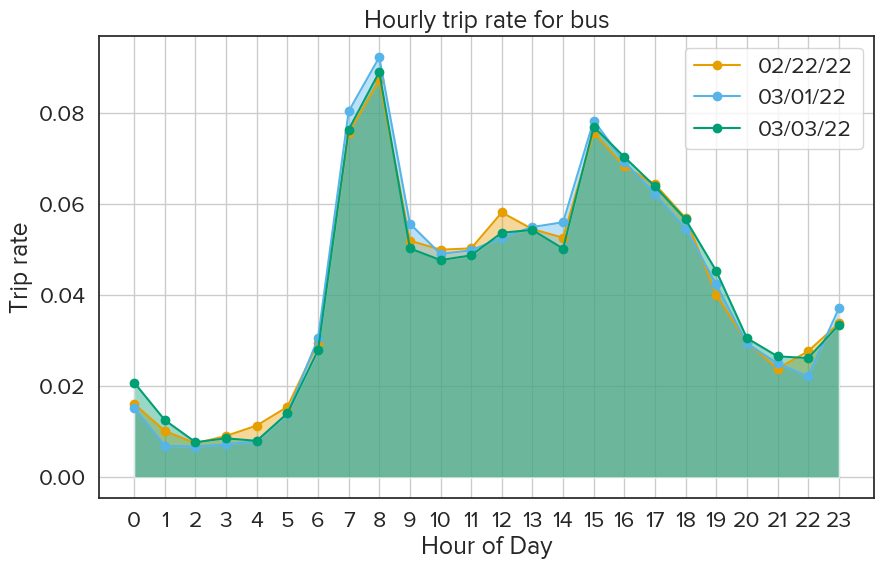

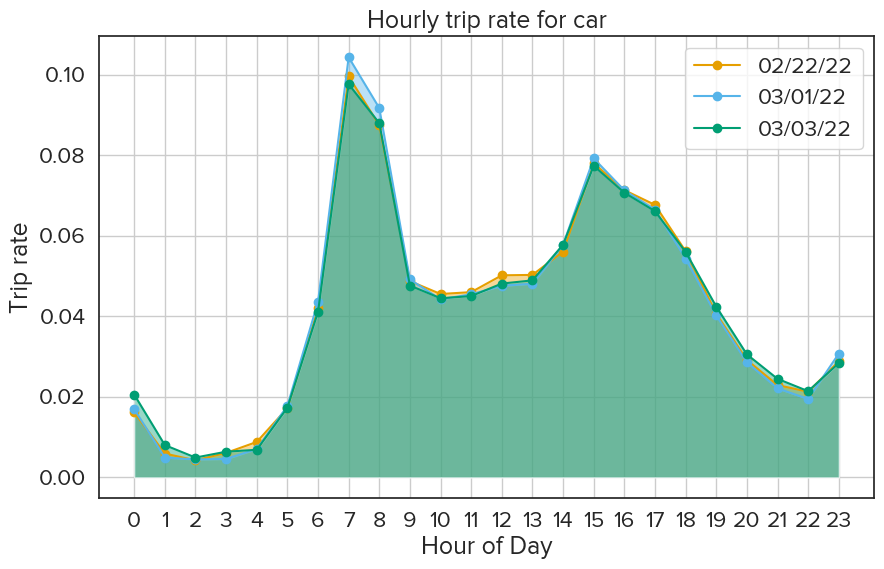

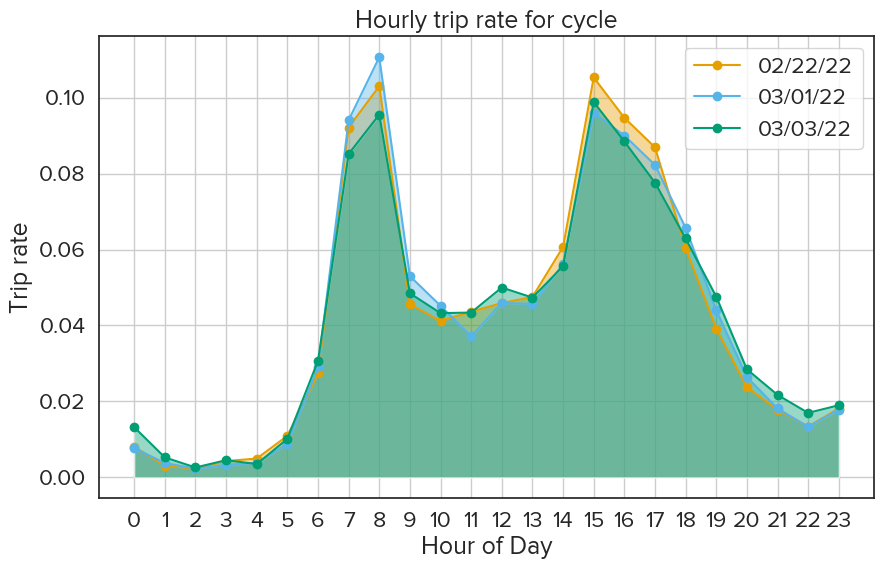

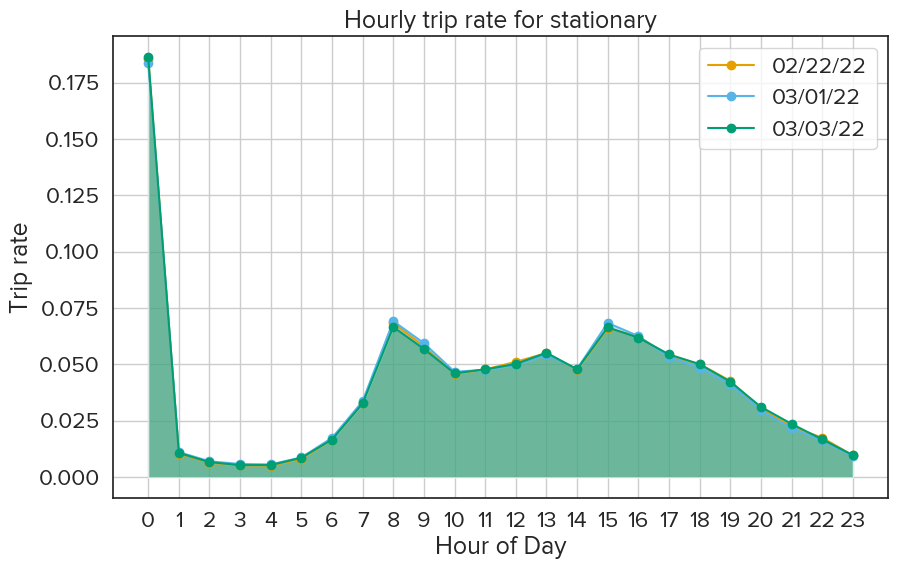

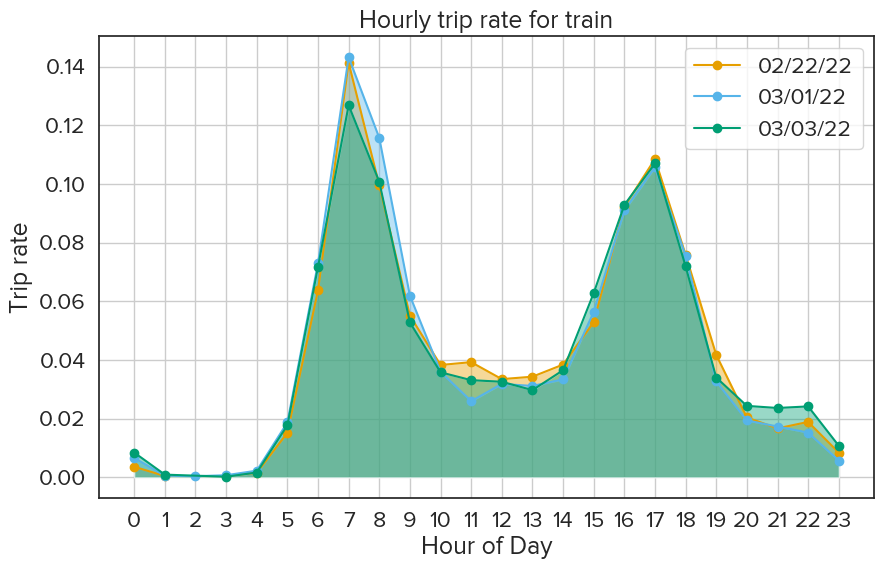

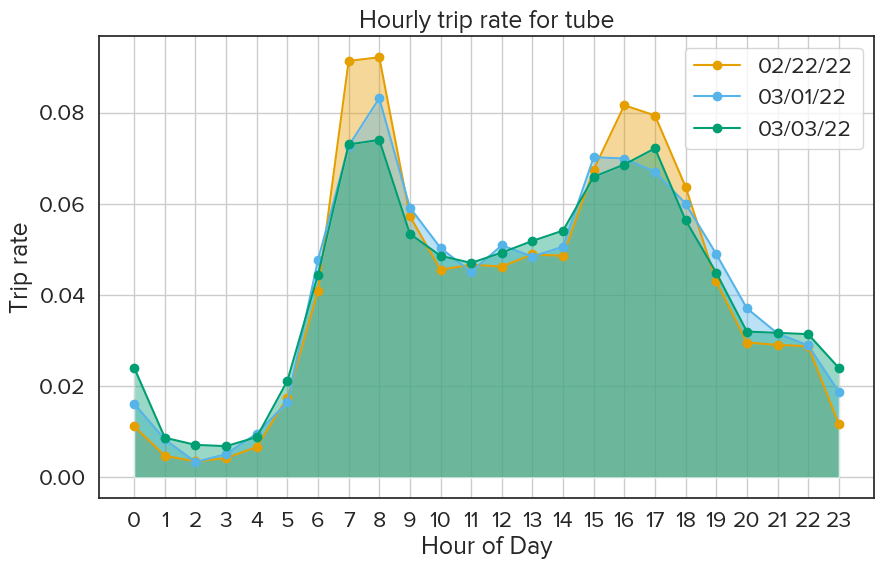

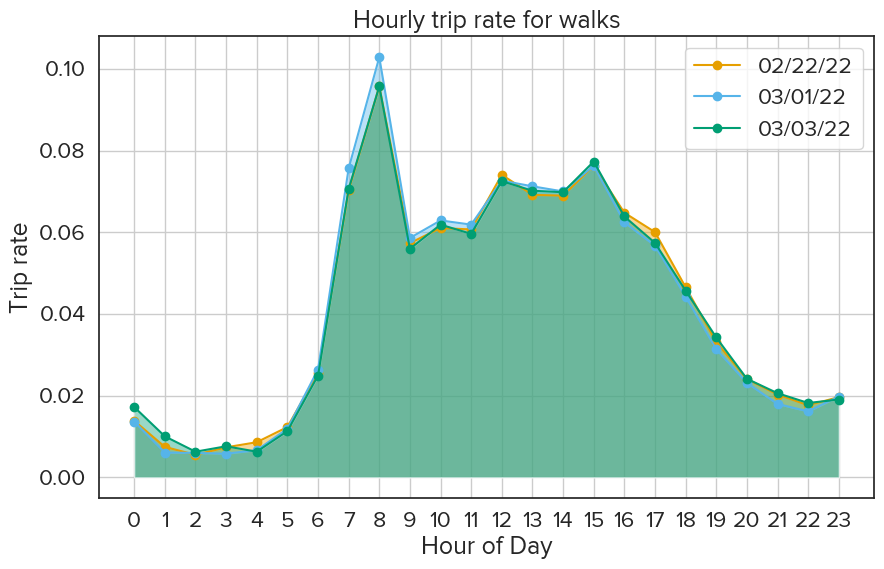

In [21]:

# Get unique modes for plotting
modes = info_rate['update_mode'].unique()
dates = info_rate['date'].unique()[[1, 8, 10]]
# plt.figure(figsize=(10, 6))
# Plot each mode
for mode in modes:
    # Filter the DataFrame for the current mode
    mode_df = info_rate[info_rate['update_mode'] == mode]

    plt.figure(figsize=(10, 6))
    
    for date in dates:
        
        # Filter the DataFrame for the current date
        date_df = mode_df[mode_df['date'] == date]
        plt.plot(date_df['start_hour'], date_df['rate'], marker='o', label=date)
        plt.fill_between(date_df['start_hour'], date_df['rate'], alpha=0.4)
        # plt.bar(date_df['start_hour'], date_df['rate'], label=date)

    plt.title(f'Hourly trip rate for {mode}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Trip rate')
    plt.xticks(range(0, 24))  # Ensure x-axis ticks for each hour
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
od

In [ ]:
# Create a new directed graph
G = nx.DiGraph()

# Iterate over the rows of the DataFrame
for index, row in od.iterrows():
    # Extract origin and destination from the current row
    origin = row['origin']
    destination = row['destination']

    # Add origin and destination nodes to the graph if they don't already exist
    G.add_node(origin)
    G.add_node(destination)

    # Add an edge from origin to destination
    G.add_edge(origin, destination)

    # add attributes to the edges

    G.add_edge(row['origin'], row['destination'], flows=row['flows'])

    # add geometry to the nodes
    G.nodes[row['origin']]['geometry'] = msoa[msoa['msoa21cd'] == row['origin']]['geometry'].values[0]
    G.nodes[row['destination']]['geometry'] = msoa[msoa['msoa21cd'] == row['destination']]['geometry'].values[0]

# get the descriptin of the graph
print(f'graph is directed: {nx.is_directed(G)}')
print(f'graph is acyclic: {nx.is_directed_acyclic_graph(G)}')
print(f'graph is bipartite: {nx.is_bipartite(G)}')
print(f'graph is planar: {nx.check_planarity(G)}')

edges_list = list(G.edges())

if edges_list:
    u, v = edges_list[100]
    edge_attr = G[u][v]

    print(f"The first edge：({u}, {v})")
    print("Attribute：", edge_attr)
else:
    print("No edge in the graph.")

In [ ]:

# Function to calculate control points for Bezier curves
def get_control_points(x0, y0, x1, y1, curvature_scale=0.2):
    dx = x1 - x0
    dy = y1 - y0
    ctrl_x = x0 + dx * curvature_scale
    ctrl_y = y0 + dy * curvature_scale + np.linalg.norm([dx, dy]) * curvature_scale
    return ctrl_x, ctrl_y


# Draw the graph
plt.figure(figsize=(10, 10), dpi=500)
msoa.plot(ax=plt.gca(), color='lightgrey', edgecolor='white', linewidth=1)

# Draw nodes
for node in G.nodes():
    x, y = G.nodes[node]['geometry'].centroid.xy
    plt.plot(x, y, 'r', markersize=1, color='white')

# Draw edges as Bezier curves
for edge in G.edges():
    origin = edge[0]
    destination = edge[1]

    # Get positions of origin and destination nodes
    x0, y0 = G.nodes[origin]['geometry'].centroid.xy
    x1, y1 = G.nodes[destination]['geometry'].centroid.xy

    # Calculate control points for a Bezier curve
    ctrl_x, ctrl_y = get_control_points(x0[0], y0[0], x1[0], y1[0])

    # # Print statements to debug
    # print("Origin:", x0, y0)
    # print("Destination:", x1, y1)
    # print("Control point:", ctrl_x, ctrl_y)

    # Create Bezier curve
    bezier_path = np.array([
        [x0[0], y0[0]],
        [ctrl_x, ctrl_y],
        [x1[0], y1[0]]
    ])

    # Plot Bezier curve
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    path = Path(bezier_path, codes)
    # take the flows as the width of the edges
    patch = patches.PathPatch(path, facecolor='none', lw=edge_attr['flows'] / 10, edgecolor='black')
    plt.gca().add_patch(patch)

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.title(f'OD flows between MSOAs at {od.date.unique()}')
plt.show()